# Test

In [282]:
load_model = True

print(f"Load model : {load_model}")

if load_model:

    trial_test = '01'
    epoch_test = 499

    save_path = join(main_path,'result/latent_210/main_result/AE')
    load_test_model = join(save_path, trial_test + '_best_AE_epoch%d.pkl' % epoch_test)
    
    model_result = AutoEncoder().to(device) # AutoEncoder LinearVAE
    model_result.load_state_dict(torch.load(load_test_model), strict=False) # best_model torch.load(load_test_model)

# print(load_test_model)

else:
    model_result = AutoEncoder().to(device) # AutoEncoder LinearVAE
    model_result.load_state_dict(best_model.state_dict(), strict=False) # best_model torch.load(load_test_model)

# test_loss, latent, x1, x1_hat, recon_loss = test(model_result, test_loader, layer='AE3')

test_loss, x_test, x_hat_test, _, latent_test = validate(model_result, test_loader, layer='AE') # test_loader lemon_loader

print(f'test loss: {test_loss:.4f}')

test_result = torch.cat(latent_test).detach().cpu().numpy()

Load model : True
test loss: 127.9945


In [1740]:
np.save(join(main_path,'result/latent_210/Ablation','top40','test_latent.npy'), test_result)

In [538]:
grad_hat_testset = torch.cat(x_hat_test).detach().cpu().numpy()
np.save(join(main_path,'result/latent_210/main_result/AE','grad_hat_testset.npy'), grad_hat_testset)

# Reconstruction evaluate

In [285]:
x = torch.cat(x_test).detach().cpu().numpy()
y = torch.cat(x_hat_test).detach().cpu().numpy()

corr_test = np.array([sc.stats.pearsonr(x[i],y[i])[0] for i in range(len(x))])
p_test = np.array([sc.stats.pearsonr(x[i],y[i])[1] for i in range(len(x))])

print(corr_test.mean())
print(np.median(corr_test))
print(corr_test.max())
print(corr_test.min())
print(corr_test.std())

0.6930863768508597
0.7018700223310033
0.7879505085293808
0.5622931085213652
0.059228881874510114


([<matplotlib.axis.YTick at 0x7fb90855d8e0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

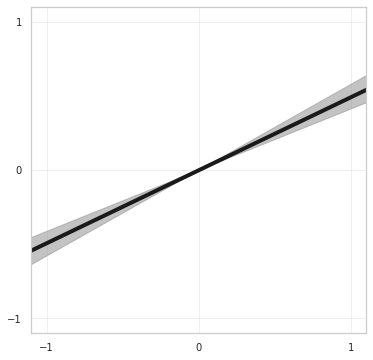

In [292]:
from statsmodels.tools.tools import add_constant

test_corr_a = np.median(corr_test) + corr_test.std(axis=0)
test_corr_b = np.median(corr_test) - corr_test.std(axis=0)

median_idx = np.where(corr_test==np.median(corr_test))[0]

x_pred = np.linspace(x[median_idx].min(),x[median_idx].max(),50)
x_pred2 = add_constant(x_pred)
y_pred = x_pred*np.median(corr_test)*np.median(corr_test)
upper = x_pred*test_corr_a*test_corr_a 
lower = x_pred*test_corr_b*test_corr_b 

plt.figure(1, figsize=(6,6))
plt.plot(x_pred,y_pred, linewidth=4, color='k')
plt.fill_between(x_pred, lower, upper,color='#888888', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xlim(-1.1,1.1)
plt.xticks([-1,0,1], fontsize=10)
plt.ylim(-1.1,1.1)
plt.yticks([-1,0,1], fontsize=10)

<Figure size 432x288 with 0 Axes>

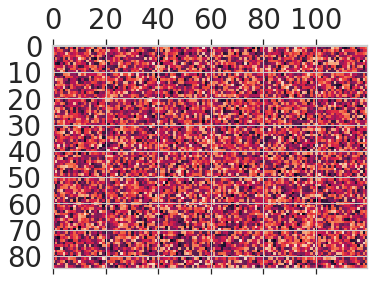

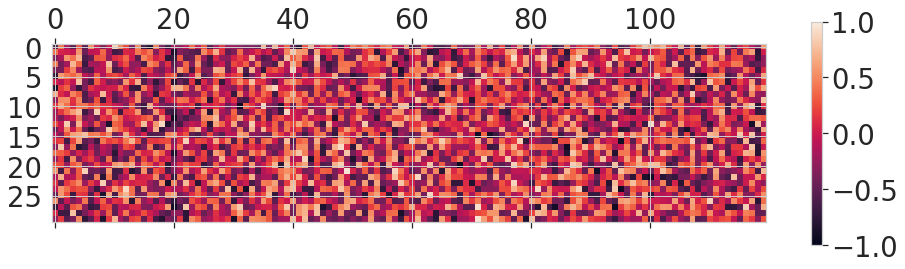

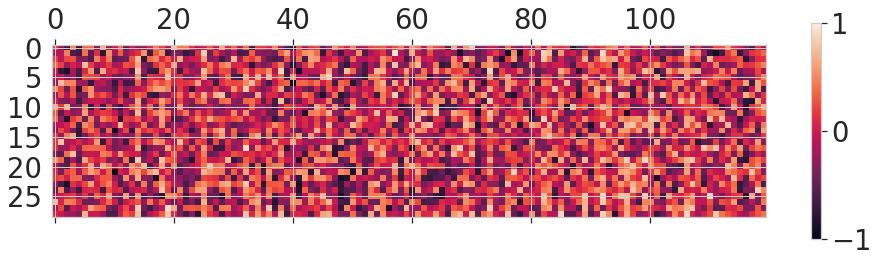

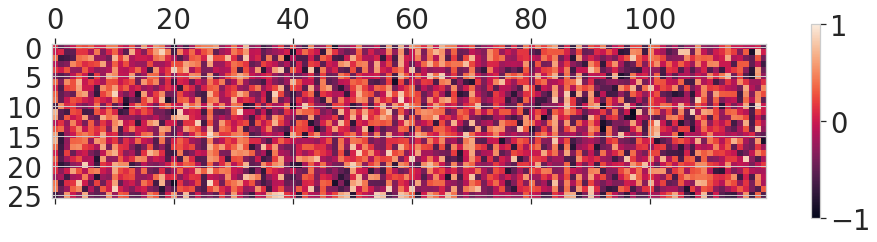

In [1969]:
# final_latent_test = result
final_latent_test

plt.figure(1)
plt.matshow(final_latent_test)

plt.figure(2)
plt.matshow(final_latent_test[np.where(label_manual==0)[0]])
plt.clim(-1,1)
plt.colorbar()

plt.figure(3)
plt.matshow(final_latent_test[np.where(label_manual==1)[0]])
plt.clim(-1,1)
plt.colorbar()

plt.figure(4)
plt.matshow(final_latent_test[np.where(label_manual==2)[0]])
plt.clim(-1,1)
plt.colorbar()

# Consensus clustering definition

In [17]:
import numpy as np
from itertools import combinations
import bisect
import matplotlib.pyplot as plt

class ConsensusCluster:
    """
      Implementation of Consensus clustering, following the paper
      https://link.springer.com/content/pdf/10.1023%2FA%3A1023949509487.pdf
      Args:
        * cluster -> clustering class
        * NOTE: the class is to be instantiated with parameter `n_clusters`,
          and possess a `fit_predict` method, which is invoked on data.
        * L -> smallest number of clusters to try
        * K -> biggest number of clusters to try
        * H -> number of resamplings for each cluster number
        * resample_proportion -> percentage to sample
        * Mk -> consensus matrices for each k (shape =(K,data.shape[0],data.shape[0]))
                (NOTE: every consensus matrix is retained, like specified in the paper)
        * Ak -> area under CDF for each number of clusters 
                (see paper: section 3.3.1. Consensus distribution.)
        * deltaK -> changes in areas under CDF
                (see paper: section 3.3.1. Consensus distribution.)
        * self.bestK -> number of clusters that was found to be best
      """

    def __init__(self, cluster, L, K, H, resample_proportion=0.5):
        assert 0 <= resample_proportion <= 1, "proportion has to be between 0 and 1"
        self.cluster_ = cluster
        self.resample_proportion_ = resample_proportion
        self.L_ = L
        self.K_ = K
        self.H_ = H
        self.Mk = None
        self.Ak = None
        self.deltaK = None
        self.bestK = None

    def _internal_resample(self, data, proportion):
        """
        Args:
          * data -> (examples,attributes) format
          * proportion -> percentage to sample
        """
        resampled_indices = np.random.choice(
            range(data.shape[0]), size=int(data.shape[0]*proportion), replace=False)
        return resampled_indices, data[resampled_indices, :]

    def fit(self, data, verbose=False):
        """
        Fits a consensus matrix for each number of clusters

        Args:
          * data -> (examples,attributes) format
          * verbose -> should print or not
        """
        Mk = np.zeros((self.K_-self.L_, data.shape[0], data.shape[0]))
        Is = np.zeros((data.shape[0],)*2)
        plot_Ak = []
        for k in range(self.L_, self.K_):  # for each number of clusters
            i_ = k-self.L_
            if verbose:
                print("At k = %d, aka. iteration = %d" % (k, i_))
            for h in range(self.H_):  # resample H times
                if verbose:
                    print("\tAt resampling h = %d, (k = %d)" % (h, k))
                resampled_indices, resample_data = self._internal_resample(
                    data, self.resample_proportion_)
                Mh = self.cluster_(n_clusters=k).fit_predict(resample_data)
                # find indexes of elements from same clusters with bisection
                # on sorted array => this is more efficient than brute force search
                id_clusts = np.argsort(Mh)
                sorted_ = Mh[id_clusts]
                for i in range(k):  # for each cluster
                    ia = bisect.bisect_left(sorted_, i)
                    ib = bisect.bisect_right(sorted_, i)
                    is_ = id_clusts[ia:ib]
                    ids_ = np.array(list(combinations(is_, 2))).T
                    # sometimes only one element is in a cluster (no combinations)
                    if ids_.size != 0:
                        Mk[i_, ids_[0], ids_[1]] += 1
                # increment counts
                ids_2 = np.array(list(combinations(resampled_indices, 2))).T
                Is[ids_2[0], ids_2[1]] += 1
            Mk[i_] /= Is+1e-8  # consensus matrix
            # Mk[i_] is upper triangular (with zeros on diagonal), we now make it symmetric
            Mk[i_] += Mk[i_].T
            Mk[i_, range(data.shape[0]), range(
                data.shape[0])] = 1  # always with self
            Is.fill(0)  # reset counter
        self.Mk = Mk
        # fits areas under the CDFs
        self.Ak = np.zeros(self.K_-self.L_)
        for i, m in enumerate(Mk):
            hist, bins = np.histogram(m.ravel(), density=True)
            self.Ak[i] = np.sum(h*(b-a)
                             for b, a, h in zip(bins[1:], bins[:-1], np.cumsum(hist)))
            
            for b, a, h in zip(bins[1:], bins[:-1], np.cumsum(hist)):
                plot_Ak.append(h*(b-a))
#             print(plot_Ak)
            
        # fits differences between areas under CDFs
        self.deltaK = np.array([(Ab-Aa)/Aa if i >= 2 else Aa
                                for Ab, Aa, i in zip(self.Ak[1:], self.Ak[:-1], range(self.L_, self.K_-1))])
        self.bestK = np.argmax(self.deltaK) + \
            self.L_ if self.deltaK.size > 0 else self.L_
        print(f'AK = {self.Ak}')
        print(f'deltaK = {self.deltaK}')
        
        return self.Mk, self.Ak, self.deltaK
       
    def predict(self):
        """
        Predicts on the consensus matrix, for best found cluster number
        """
        assert self.Mk is not None, "First run fit"
        return self.cluster_(n_clusters=self.bestK).fit_predict(
            1-self.Mk[self.bestK-self.L_])

    def predict_data(self, data):
        """
        Predicts on the data, for best found cluster number
        Args:
          * data -> (examples,attributes) format 
        """
        assert self.Mk is not None, "First run fit"
        return self.cluster_(n_clusters=self.bestK).fit_predict(
            data)

# Consensus clustering

In [3907]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

cc = ConsensusCluster(KMeans, 2, 9, 100, resample_proportion=0.9) # KMeans # AgglomerativeClustering # SpectralClustering

Mk, Ak, deltak = cc.fit(result) # train_result valid_result test_result

cluster_labels = cc.predict_data(result) # train_result valid_result test_result
cluster_labels

AK = [5.49591696 5.11986159 5.5767474  6.05370242 5.68678201 5.99321799
 6.36359862]
deltaK = [-0.0684245   0.08923792  0.08552566 -0.06061091  0.05388566  0.06179996]


<ipython-input-1808-bdf49685d809>:96: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.Ak[i] = np.sum(h*(b-a)


array([0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 1,
       0, 0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0,
       0, 2, 2, 1, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 2, 0, 2, 1, 0,
       0, 0, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2],
      dtype=int32)

Text(0, 0.5, 'Consensus coefficient')

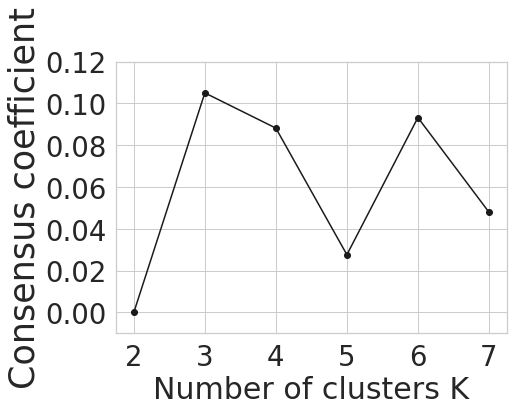

In [247]:
# latent 210 result Optimal K

deltak = [-0.11931122,  0.10498302,  0.0881342,   0.02758437,  0.09317429,  0.04796325]

sns.set(style = 'whitegrid', font_scale=2.5)
plt.figure(1, (7,5))
plt.plot([2,3,4,5,6,7],[i if i >0 else 0 for i in deltak], '-o', color='k')
plt.ylim([-0.01,0.1])
plt.xticks([2,3,4,5,6,7])
plt.yticks([0,0.02,0.04,0.06,0.08,0.1, 0.12])
plt.xlabel('Number of clusters K')
plt.ylabel('Consensus coefficient', fontsize=35)

In [435]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

clusterer = KMeans(n_clusters=3) # KMeans AgglomerativeClustering
# clusterer = GaussianMixture(n_components=3, random_state=None) # GaussianMixture
cluster_label = clusterer.fit_predict(result) # train_result valid_result test_result 
# cluster_label
label_idx = label_subj(cluster_label)

sub1 = label_idx[0]
sub2 = label_idx[1]
sub3 = label_idx[2]

print(sub1, '\n',sub2, '\n',sub3)

In [18]:
# 210 Main cluster label
cluster_label_AE = np.array([2, 0, 1, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 2, 2, 0,
       0, 1, 1, 0, 1, 0, 2, 0, 2, 2, 1, 0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1,
       0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 2,
       2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 1, 2, 2, 1])

sub_idx = label_subj(cluster_label_AE)

sub1_AE = sub_idx[0]
sub2_AE = sub_idx[1]
sub3_AE = sub_idx[2]

print(sub1_AE, '\n',sub2_AE, '\n',sub3_AE)

label 0 : 34
label 1 : 21
label 2 : 30
[ 1  8  9 10 14 15 16 21 22 25 27 29 33 34 38 39 44 46 47 48 50 52 57 58
 59 61 62 64 69 70 71 74 77 80] 
 [ 2  5  7 12 13 18 23 24 26 32 41 43 45 63 72 73 75 76 78 81 84] 
 [ 0  3  4  6 11 17 19 20 28 30 31 35 36 37 40 42 49 51 53 54 55 56 60 65
 66 67 68 79 82 83]


# Plot one

(-1.0, 20.0)

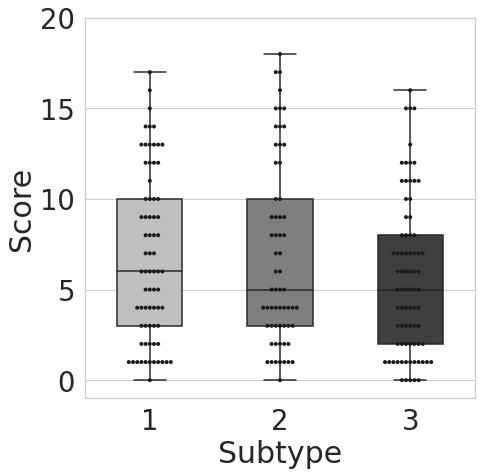

In [559]:
import seaborn as sns

y = TFEQ_F1 # BMI WHR EDE_Q_R EDE_Q_con EDE_Q_E_con EDE_Q_S_con EDE_Q_W_con TFEQ_F1 TFEQ_F2 TFEQ_F3 

idx = otest_idx # itrain_idx itest_idx otest_idx

df = pd.DataFrame([np.array(y), cluster_label_lemon+1]) # cluster_labels  label_manual
df = df.T
df.columns = ['Score','Subtype']

plt.figure(1,(7,7))
sns.set(style = 'whitegrid', font_scale=2.5)
sns.boxplot(x = df.columns[1] , y = df.columns[0], data = df, palette = 'gist_yarg', width=0.5)
sns.swarmplot(x = df.columns[1] , y = df.columns[0], data = df, color = 'k', size = 4)

plt.ylim([-1,20])
# plt.yticks([20,25,30,35,40])

# Plot all

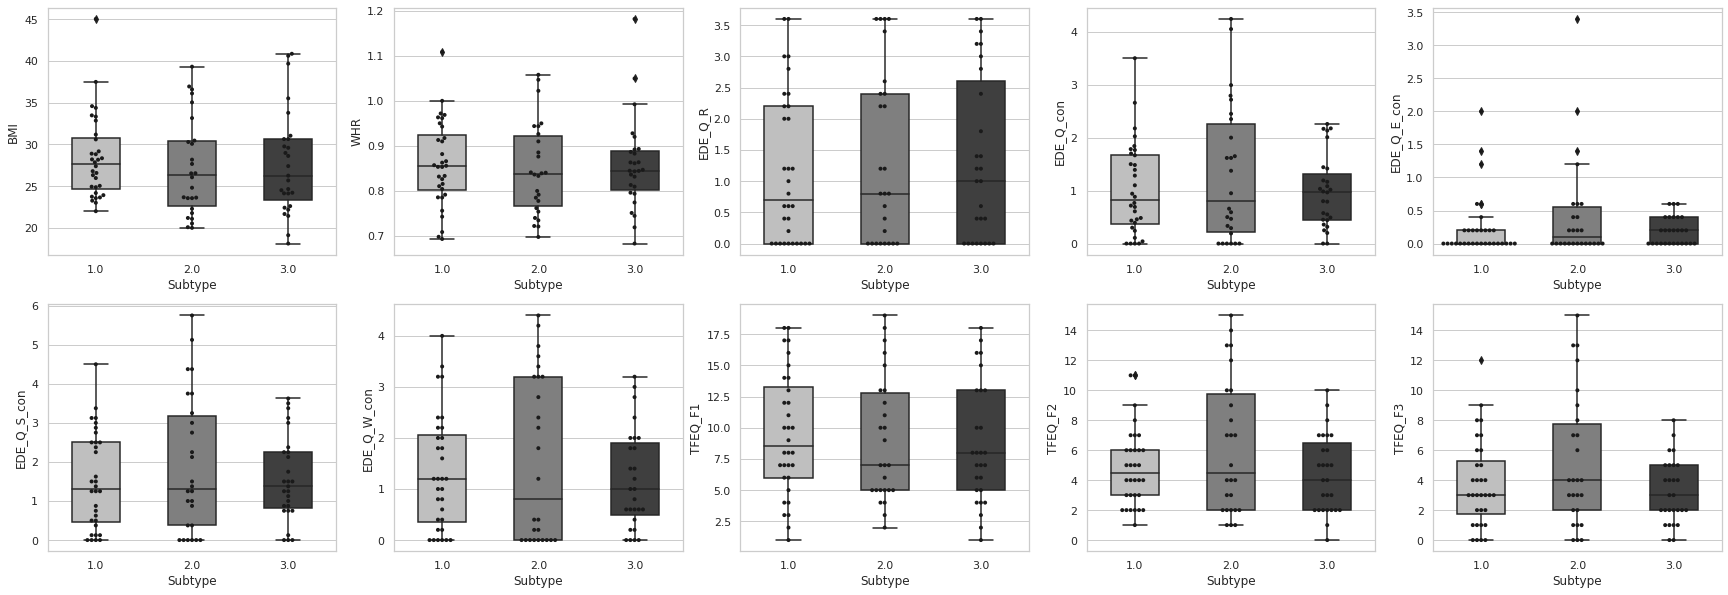

In [70]:
# trial = 0
score_plot(trial, otest_idx, cluster_label_420+1, save=False, plot_close=False)

# Statistical analysis (score)

In [65]:
trial=1

stat_result(trial, main_otest_idx, main_cluster_label, save=False, result_show = True)

In [150]:
subtype_score(cluster_label_AE, main_otest_idx) # cluster_label_gradient cluster_label_AE

# subtype_score(cluster_label_lemon, np.arange(212)) # Lemon

BMI
27.43 +- 3.59
29.36 +- 7.73
27.19 +- 5.51

TFEQ_F1
9.85 +- 4.57
8.05 +- 5.08
8.83 +- 4.85

TFEQ_F2
4.62 +- 2.41
6.86 +- 4.36
4.47 +- 2.93

TFEQ_F3
3.41 +- 2.78
5.57 +- 4.01
3.63 +- 2.99



In [62]:
BMI_sub1_main = np.array(BMI)[main_otest_idx][sub1_main]
BMI_sub2_main = np.array(BMI)[main_otest_idx][sub2_main]
BMI_sub3_main = np.array(BMI)[main_otest_idx][sub3_main]

TFEQ_F1_sub1_main = np.array(TFEQ_F1)[main_otest_idx][sub1_main]
TFEQ_F1_sub2_main = np.array(TFEQ_F1)[main_otest_idx][sub2_main]
TFEQ_F1_sub3_main = np.array(TFEQ_F1)[main_otest_idx][sub3_main]

TFEQ_F2_sub1_main = np.array(TFEQ_F2)[main_otest_idx][sub1_main]
TFEQ_F2_sub2_main = np.array(TFEQ_F2)[main_otest_idx][sub2_main]
TFEQ_F2_sub3_main = np.array(TFEQ_F2)[main_otest_idx][sub3_main]

TFEQ_F3_sub1_main = np.array(TFEQ_F3)[main_otest_idx][sub1_main]
TFEQ_F3_sub2_main = np.array(TFEQ_F3)[main_otest_idx][sub2_main]
TFEQ_F3_sub3_main = np.array(TFEQ_F3)[main_otest_idx][sub3_main]

score_main = sc.io.savemat(join(main_path, 'result/latent_210/main_result/AE/score_main.mat'), {'BMI_sub1_main':BMI_sub1_main, 'BMI_sub2_main':BMI_sub2_main, 'BMI_sub3_main':BMI_sub3_main, 'TFEQ_F1_sub1_main':TFEQ_F1_sub1_main,
                                                                                              'TFEQ_F1_sub2_main':TFEQ_F1_sub2_main, 'TFEQ_F1_sub3_main':TFEQ_F1_sub3_main, 'TFEQ_F2_sub1_main':TFEQ_F2_sub1_main, 'TFEQ_F2_sub2_main':TFEQ_F2_sub2_main,
                                                                                              'TFEQ_F2_sub3_main':TFEQ_F2_sub3_main, 'TFEQ_F3_sub1_main':TFEQ_F3_sub1_main, 'TFEQ_F3_sub2_main':TFEQ_F3_sub2_main, 'TFEQ_F3_sub3_main':TFEQ_F3_sub3_main})

# Score permutation test

In [774]:
c_label = cluster_label_lemon # main_cluster_label cluster_l
random_state = 44             # main perm 2, 30% 10, 20% 0, Gau 15,AE_dropx 15, AE_420 15, AE_120 15, ME 16, gradient 16, boot_470 58, boot_562 6, boot_626 4, Lemon 44


BMI_p = permutation_ttest(BMI_lemon, np.arange(212), c_label, random_state)
TFEQ_F1_p = permutation_ttest(TFEQ_F1_lemon, np.arange(212), c_label, random_state)
TFEQ_F2_p = permutation_ttest(TFEQ_F2_lemon, np.arange(212), c_label, random_state)
TFEQ_F3_p = permutation_ttest(TFEQ_F3_lemon, np.arange(212), c_label, random_state) 

for i in [BMI_p, TFEQ_F1_p, TFEQ_F2_p, TFEQ_F3_p]:

    p_fdr = sm.stats.multitest.multipletests(i, alpha=0.05,method='fdr_bh')
    print(p_fdr[1])

p value :  0.858
p value :  0.122
p value :  0.128

p value :  0.898
p value :  0.116
p value :  0.135

p value :  0.631
p value :  0.532
p value :  0.282

p value :  0.012
p value :  0.457
p value :  0.234

[0.858 0.192 0.192]
[0.898  0.2025 0.2025]
[0.631 0.631 0.631]
[0.036 0.457 0.351]


# Significant different latent element from each subtype

In [119]:
main_otest_idx = np.load(join(main_path,'result/latent_210/main_result/AE/subj_idx.npy'), allow_pickle=True).item()['otest_idx']
main_cluster_label = np.load(join(main_path,'result/latent_210/main_result/AE/AE_cluster_label_idx.npy'))
main_latent = np.load(join(main_path,'result/latent_210/main_result/AE/latent.npy'))

sub_idx = label_subj(main_cluster_label)

sub1_main = sub_idx[0]
sub2_main = sub_idx[1]
sub3_main = sub_idx[2]

main_latent_sub1 = main_latent[sub1_main]
main_latent_sub2 = main_latent[sub2_main]
main_latent_sub3 = main_latent[sub3_main]

main_latent_sub12 = np.concatenate((main_latent_sub1,main_latent_sub2),axis=0)
main_latent_sub13 = np.concatenate((main_latent_sub1,main_latent_sub3),axis=0)
main_latent_sub23 = np.concatenate((main_latent_sub2,main_latent_sub3),axis=0)

print('')
sig_idx_sub1 = latent_sig_elem_ttest(main_latent_sub1, main_latent_sub23, 50)
print('')
sig_idx_sub2 = latent_sig_elem_ttest(main_latent_sub2, main_latent_sub13, 50)
print('')
sig_idx_sub3 = latent_sig_elem_ttest(main_latent_sub3, main_latent_sub12, 50)

label 0 : 34
label 1 : 21
label 2 : 30

총 24 개
Cohen d value : [ 1.08  0.92  1.11  1.15  1.15  1.04  0.95 -1.28  1.14 -1.18 -1.46  1.39
 -1.14  1.21  1.09  0.98  1.07  1.45  0.93  1.13 -1.23 -0.95  0.92  1.27]
Region index : [  0   9  13  14  20  25  56  63  64  68  79  95 100 102 119 139 165 170
 174 189 191 192 198 202]

총 16 개
Cohen d value : [-1.15  1.6   1.84 -1.42 -1.24  1.91  1.19 -1.55 -1.13 -1.6  -1.48 -1.63
 -1.45 -1.23 -1.24 -1.28]
Region index : [  9  24  43  51  65  68  69 119 123 139 160 162 170 188 189 190]

총 20 개
Cohen d value : [ 1.1  -1.05 -1.68  1.11 -0.97 -1.23 -1.02 -1.17 -1.4   1.29  1.2   1.09
  1.47  1.09 -1.39  1.1  -1.11 -0.95 -1.07 -1.76]
Region index : [ 11  18  20  21  50  56  69  76  85  92  94 124 134 136 144 162 165 174
 179 202]


# Model Interpretation

In [166]:
def IG_grad(sub_main_idx, sig_idx):
    X = torch.tensor(grad_list_znorm_stacked_regout[main_otest_idx][sub_main_idx]).float().to('cpu') # [subj_num, Multi-gradients]
    X.requires_grad_()

    IG_grad_elem = []
    attr_list = []
    IG_sum = np.zeros(grad_list_znorm_stacked_regout[main_otest_idx].shape)
    for i in sig_idx: # sig_idx
#         attr, delta = lrp.attribute(X,target=0, return_convergence_delta=True)
        attr = nig.attribute(X, int(i))
        attr = attr.detach().numpy()
        IG_sum += attr
    
    return IG_sum.mean(axis=0), IG_sum # Finally, attr_list_sum = IG_sum/subj_num

In [167]:
from captum.attr import IntegratedGradients, LRP, NeuronIntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

load_test_model = join(main_path,'result/latent_210/main_result/AE','01_best_AE_epoch499.pkl')

model = AutoEncoder_en().to('cpu')
model.load_state_dict(torch.load(load_test_model), strict=False)

# Model interpretation
nig = NeuronIntegratedGradients(model, model.encoder2)

IG_testmean, IG_testsum = IG_grad(np.arange(len(main_latent)), np.arange(210))

In [ ]:
IG1_testmean = IG_testsum.mean(axis=0)[:210]
IG2_testmean = IG_testsum.mean(axis=0)[210:420]
IG3_testmean = IG_testsum.mean(axis=0)[420:]

In [125]:
np.save(join(main_path,'result/latent_210/main_result/AE', 'IG_attr_sub1_test.npy'), attr_sub1)
np.save(join(main_path,'result/latent_210/main_result/AE', 'IG_attr_sub2_test.npy'), attr_sub2)
np.save(join(main_path,'result/latent_210/main_result/AE', 'IG_attr_sub3_test.npy'), attr_sub3)
np.save(join(main_path,'result/latent_210/main_result/AE', 'IG_testmean.npy'), IG_testmean)
np.save(join(main_path,'result/latent_210/main_result/AE', 'IG_testsum.npy'), IG_testsum)

# IG visualization

[-0.01581588 -0.00625967 -0.01367278 -0.01283296 -0.03194268 -0.01297374
 -0.01380843]


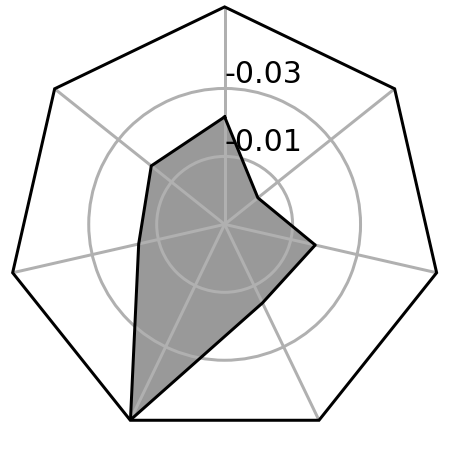

[-0.00843501 -0.01247547 -0.02012566 -0.00898759 -0.01092983 -0.00814273
 -0.01449566]


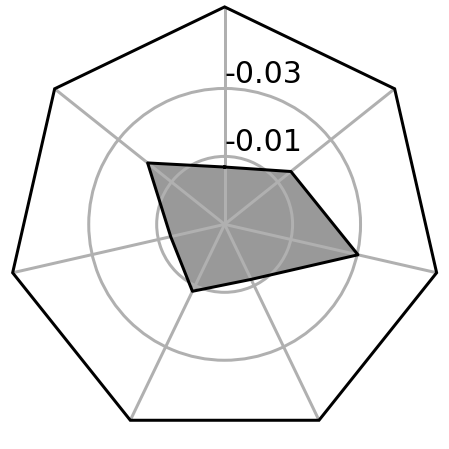

[-0.00570718 -0.01032514 -0.00852099 -0.01343572 -0.0173563  -0.01286139
 -0.01802069]


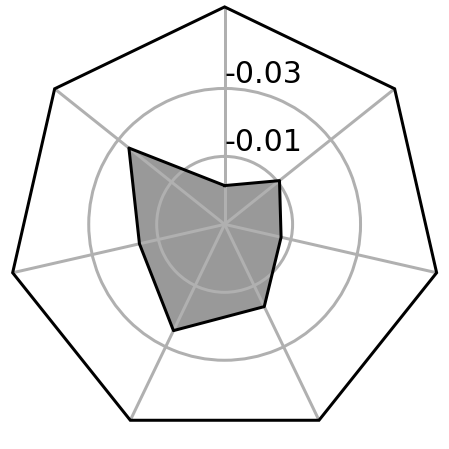

In [67]:
path_work = join(main_path,'result/latent_210')

yeo7net_withSub_label = np.load(join(path_work, 'main_result', 'AE', 'BNA2yeo7.npy'), allow_pickle = True).item()['Label_name']
BNA2yeo7_withSub_idx = np.load(join(path_work, 'main_result', 'AE', 'BNA2yeo7.npy'), allow_pickle = True).item()['BNA2yeo7_withSub_idx']

yeo7net = yeo7net_withSub_label[:7]
BNA2yeo7 = BNA2yeo7_withSub_idx[:210]

data_list = [IG1_testmean, IG2_testmean, IG3_testmean]

value_set = 'neg' # abs pos neg

for i in data_list:

#     data = np.load(join(path_work, 'main_result/AE', f'{i}')) # for MANOVA
    data = i # for DC
    
    if value_set == 'abs':
        data_yeo = np.array([abs(data)[BNA2yeo7==i].mean() for i in range(BNA2yeo7.max()+1)])
        
    if value_set == 'pos':
        data_yeo = np.array([data[BNA2yeo7==i][data[BNA2yeo7==i]>0].mean() for i in range(BNA2yeo7.max()+1)])
        
    if value_set == 'neg':
        data_yeo = np.array([data[BNA2yeo7==i][data[BNA2yeo7==i]<0].mean() for i in range(BNA2yeo7.max()+1)])
        
    print(data_yeo)
    plot_spider(data_yeo)

# Statistical analysis (MANOVA)

In [397]:
AE_otest_idx = np.load(join(main_path,'result/latent_210/main_result/AE/subj_idx.npy'), allow_pickle=True).item()['otest_idx']
AE_cluster_label = np.load(join(main_path,'result/latent_210/main_result/AE/AE_cluster_label_idx.npy'))

ME_otest_idx = np.load(join(main_path,'result/latent_210/main_result/ME/subj_idx.npy'), allow_pickle=True).item()['otest_idx']
ME_cluster_label = np.load(join(main_path,'result/latent_210/main_result/ME/ME_cluster_label_idx.npy'))

grad_list_znorm_stacked_regout = np.load(join(main_path,'result/latent_210/main_result/AE/grad_list_znorm_stacked_regout.npy'))

IG_testsum = np.load(join('/store4/hschoi/1.Eat.DNN/result/latent_210/main_result/AE','IG', 'IG_testsum.npy'))
# IG_testmean = np.load(join('/store4/hschoi/1.Eat.DNN/result/latent_210/main_result/AE', 'IG', 'IG_testmean.npy'))

In [206]:
# IG 

import statsmodels
from statsmodels.multivariate.manova import MANOVA


c_label = AE_cluster_label

sub1 = np.where(c_label==0)[0]
sub2 = np.where(c_label==1)[0]
sub3 = np.where(c_label==2)[0]

sub_label = np.zeros(len(c_label))
sub_label[sub1] = 1
sub_label[sub2] = 2
sub_label[sub3] = 3

df1 = pd.DataFrame(IG_testsum)
df1 = df1.add_prefix('ROI_')
df2 = pd.DataFrame(sub_label)
df2.columns = ['Label']

df = pd.concat([df1, df2], axis=1)
# df[['ROI_0','ROI_210','ROI_420', 'Label']]

label1 = df['Label'] == 1
label2 = df['Label'] == 2
label3 = df['Label'] == 3

label_12 = df['Label'] !=3
label_13 = df['Label'] !=2
label_23 = df['Label'] !=1

In [220]:
import statsmodels
from statsmodels.stats.multivariate import test_mvmean_2indep
# Hotelling's t2 (Multivariate t-test)

f_list = []
p_list = []
t2_list = []
t_list = []
Maha_dist = []

l1_idx = label1 # label1 label1 label2
l2_idx = label2 # label2 label3 label3

formula_idx = [[f'ROI_{i}', f'ROI_{i+210}', f'ROI_{i+420}'] for i in range(210)]

for i in range(len(formula_idx)):
    x = df[formula_idx[i]][l1_idx]
    y = df[formula_idx[i]][l2_idx]
    nx = len(x)
    ny = len(y)
    
    f_val = test_mvmean_2indep(x, y).statistic
    p_val = test_mvmean_2indep(x, y).pvalue
    t2_val = test_mvmean_2indep(x, y).t2
    t_val = t2_val**(1/2)
    Mahalanobis_dist = (nx+ny)/(nx*ny)*t2_val # Hotelling's t2 effect size
    
    f_list.append(f_val)
    p_list.append(p_val)
    t2_list.append(t2_val)
    t_list.append(t_val)
    Maha_dist.append(Mahalanobis_dist)
    
p_fdr = sm.stats.multitest.multipletests(p_list,alpha=0.01,method='fdr_bh')
print('\n')
print(len(np.where(p_fdr[0]==True)[0]), '개')
print('')
print(np.where(p_fdr[0]==True)[0])
print('')
print(np.round(p_fdr[1][np.where(p_fdr[0]==True)],5))

sig_idx = np.where(p_fdr[0]==True)[0]



11 개

[  2  24  57  64  65  78 150 152 153 154 204]

[7.07e-03 6.26e-03 7.49e-03 6.26e-03 6.26e-03 4.17e-03 4.00e-05 1.49e-03
 4.17e-03 6.26e-03 6.26e-03]


In [198]:
import statsmodels as sm
from statsmodels.multivariate.manova import MANOVA

# Multivariate ANOVA

f0_list = []
eta_list = []
p0_list = []

formula_idx = [f'ROI_{i} + ROI_{i+210} + ROI_{i+420} ~ Label' for i in range(210)]

for i in range(len(formula_idx)):
    print(i, ' ', end = '', flush = True)
    data = df # df 
    maov = MANOVA.from_formula(formula_idx[i], data = data) # df df[label_01] df[label_02] df[label_12]
    # print(maov.mv_test())
    f0 = maov.mv_test().results['Label']['stat']['F Value'].values[1] # Pillai's trace F value
    v0 = maov.mv_test().results['Label']['stat']['Value'].values[1] # Pillai's trace V value
    p0 = maov.mv_test().results['Label']['stat']['Pr > F'].values[1]
    df1 = maov.mv_test().results['Label']['stat']['Num DF'].values[2]
    df2 = maov.mv_test().results['Label']['stat']['Den DF'].values[2]
    eta_squared = (df1*f0)/(df1*f0+df2) # MANOVA F effect size

    f0_list.append(f0)
    eta_list.append(eta_squared)
    p0_list.append(p0)

    
p_0_fdr = sm.stats.multitest.multipletests(p0_list,alpha=0.05,method='fdr_bh')
print('\n')
print(len(np.where(p_0_fdr[0]==True)[0]), '개')
print('')
print(np.where(p_0_fdr[0]==True)[0])
print('')
print(np.round(p_0_fdr[1][np.where(p_0_fdr[0]==True)],5))

sig_idx = np.where(p_0_fdr[0]==True)[0]

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  

72 개

[  2  12  15  20  21  22  23  24  25  31  38  39  48